In [90]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
from datetime import datetime
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [91]:
def prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name):
    def _compute_test_f1_score_helper(lines):
        total_time = 0
        i = 0
        while i < len(lines):
            # if "UDF selection finished" in lines[i]:
            #     i += 1
            #     break
            if "compute test F1 score" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    pattern = r"positive: (-?\d+), negative: (-?\d+)"
                    match = re.search(pattern, lines[j])
                    if match:
                        if "UDFCandidate" in lines[j+1]:
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                            end_datetime = datetime.strptime(datetime_str, dt_format)
                            end_index = j + 1
                        else:
                            # data.append((dataset, query_class_name, question_id, run_id, "udf selection", "computing test score", (end_datetime - start_datetime).total_seconds()))
                            print(i, end_index, (end_datetime - start_datetime).total_seconds())
                            total_time += (end_datetime - start_datetime).total_seconds()
                            end_index = j
                            break
                i = end_index
            i += 1
        return total_time

    data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time)
    udf_generation_data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time)
    cost_data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, cost)
    for num_missing_udfs in num_missing_udfs_list:
        for query_class_name in query_class_names:
            for run_id in run_ids:
                for question_id in question_ids:
                    try:
                        print(f"query_class_name={query_class_name}, question_id={question_id}, run_id={run_id}")
                        with open(os.path.join(config['log_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                        # Total generation time
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()
                        dt_format = "%Y-%m-%d %H:%M:%S,%f"
                        start_datetime = datetime.strptime(datetime_str, dt_format)
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[-1]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        total_generation_time = (end_datetime - start_datetime).total_seconds()
                        # data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "total_generation", (end_datetime - start_datetime).total_seconds()])

                        udf_selection_time = 0
                        udf_generation_other_time = 0
                        for line in lines[::-1]:
                            if "Total execution time:" in line:
                                match = re.search(r"Total execution time: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                execution_time = eval(dict_str)
                                for type, time in execution_time.items():
                                    if type == "udf_generation":
                                        udf_generation_other_time += time

                                    if type == "udf_selection":
                                        udf_selection_time = time
                                    else:
                                        data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time])
                            elif "UDF generation execution time:" in line:
                                match = re.search(r"UDF generation execution time: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                execution_time = eval(dict_str)
                                for type, time in execution_time.items():
                                    udf_generation_data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time])
                                    udf_generation_other_time -= time
                            elif "Cost estimation:" in line:
                                match = re.search(r"Cost estimation: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                cost_dict = eval(dict_str)
                                for type, cost in cost_dict.items():
                                    cost_data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, type, cost])
                        udf_generation_data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "other", udf_generation_other_time])

                        # Remove the time spent on computing test F1 score from the time spent on UDF selection
                        test_f1_score_time = _compute_test_f1_score_helper(lines)
                        udf_selection_time -= test_f1_score_time
                        total_generation_time -= test_f1_score_time
                        data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "udf_selection", udf_selection_time])
                        data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "total_generation", total_generation_time])
                    except Exception as e:
                        print(e)
                        continue

                    try:
                        with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                            # print("query execution")
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()

                            # Convert the extracted string to a datetime object
                            dt_format = "%Y-%m-%d %H:%M:%S,%f"
                            start_datetime = datetime.strptime(datetime_str, dt_format)
                            for line in lines:
                                if "Peak memory usuage" in line:
                                    datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", line).group()
                                    end_datetime = datetime.strptime(datetime_str, dt_format)
                                    data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "query_execution", (end_datetime - start_datetime).total_seconds()])
                                    break
                    except Exception as e:
                        print(e)
                        continue
    return data, udf_generation_data, cost_data

In [92]:
data = []
udf_generation_data = []
cost_data = []

# Clevrer
dataset = "clevrer"
query_class_names = [
    "3_new_udfs_labels",
]
# question_ids = list(range(30))
question_ids = list(range(10))
# run_ids = list(range(3))
run_ids = [0]
num_missing_udfs_list = list(range(4))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-labels=user-budget=20-llm_method=gpt4v"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

# CityFlow
dataset = "cityflow"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    # "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
# question_ids = list(range(15))
question_ids = list(range(10))
# run_ids = list(range(3))
run_ids = [0]
num_missing_udfs_list = list(range(3))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

# Charades
dataset = "charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    # "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    # "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
# run_ids = list(range(3))
run_ids = [0]
num_missing_udfs_list = list(range(3))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

total_time_df = pd.DataFrame(data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "time"])
udf_generation_time_df = pd.DataFrame(udf_generation_data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "time"])
cost_df = pd.DataFrame(cost_data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "cost"])

query_class_name=3_new_udfs_labels, question_id=0, run_id=0
query_class_name=3_new_udfs_labels, question_id=1, run_id=0
query_class_name=3_new_udfs_labels, question_id=2, run_id=0
query_class_name=3_new_udfs_labels, question_id=3, run_id=0
query_class_name=3_new_udfs_labels, question_id=4, run_id=0
query_class_name=3_new_udfs_labels, question_id=5, run_id=0
query_class_name=3_new_udfs_labels, question_id=6, run_id=0
query_class_name=3_new_udfs_labels, question_id=7, run_id=0
query_class_name=3_new_udfs_labels, question_id=8, run_id=0
query_class_name=3_new_udfs_labels, question_id=9, run_id=0
query_class_name=3_new_udfs_labels, question_id=0, run_id=0
33347 33479 30.36
43044 43296 17.039
query_class_name=3_new_udfs_labels, question_id=1, run_id=0
query_class_name=3_new_udfs_labels, question_id=2, run_id=0
25038 29873 496.288
query_class_name=3_new_udfs_labels, question_id=3, run_id=0
25835 26084 25.712
query_class_name=3_new_udfs_labels, question_id=4, run_id=0
query_class_name=3_new_u

In [93]:
print(udf_generation_time_df.to_string())

      dataset  num_missing_udfs                                                                                                          query_class_name  question_id  run_id                                type        time
0     clevrer                 0                                                                                                         3_new_udfs_labels            0       0                               other    0.000000
1     clevrer                 0                                                                                                         3_new_udfs_labels            1       0                               other    0.000000
2     clevrer                 0                                                                                                         3_new_udfs_labels            2       0                               other    0.000000
3     clevrer                 0                                                                             

In [94]:
# Sanity check
# def sanity_check(df):
#     df_total_generation = df[df["type"] == "total_generation"]
#     df_total_generation = df_total_generation[["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "time"]]
#     df_total_generation = df_total_generation.rename(columns={"time": "total_generation_time"})

#     df_filtered = df[(df["type"] != "total_generation") & (df["type"] != "query_execution")]
#     # group by query_class_name, question_id, run_id, and then sum the time column
#     df_filtered = df_filtered.groupby(["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id"]).agg({"time": "sum"}).reset_index()
#     df_filtered = df_filtered.rename(columns={"time": "sum_time"})
#     df_filtered = df_filtered.merge(df_total_generation, on=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id"], how="left")
#     # compute percentage difference as a new column
#     df_filtered["percentage"] = (df_filtered["total_generation_time"] - df_filtered["sum_time"]) / df_filtered["total_generation_time"] * 100

#     print(df_filtered.to_string())

# sanity_check(total_time_df)

In [95]:
# print(df.to_string())

In [104]:
def plot_total_time_breakdown(dataset, target_df, title_name, x_label):
    fig, ax = plt.subplots(figsize=(5, 2))
    df_plot = target_df[(target_df["type"] != "total_generation")]
    df_plot = df_plot[df_plot["dataset"] == dataset]
    df_plot = df_plot.drop(columns=["dataset"])

    df_plot = df_plot.groupby(["num_missing_udfs", "query_class_name", "question_id", "run_id", "type"]).agg({x_label: "sum"}).reset_index()

    # convert time to minutes
    if x_label == "time":
        df_plot.loc[:, x_label] = df_plot[x_label] / 60

    cmap = plt.get_cmap('tab20')
    hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']

    # Plotting each type as a stack
    if title_name == "total_time":
        types = ["resource_init", "query_parsing", "udf_proposal", "udf_generation", "udf_selection", "query_execution"]
    elif title_name == "udf_generation_time":
        types = ["program_generation", "model_distillation_init", "model_distillation_data_loading", "model_distillation_data_labeling", "model_distillation_model_training", "model_distillation_active_learning", "other"]
    elif title_name == "cost":
        types = ["query_parser", "propose_udfs", "generate_program", "model_udf_data_labeling", "verify_syntax_correctness"]
    bottom = pd.Series([0.0] * len(df_plot['num_missing_udfs'].unique()), index=df_plot['num_missing_udfs'].unique())
    all_num_missing_udfs = df_plot['num_missing_udfs'].unique()
    y_positions = [0, 0.5, 1, 1.5][:all_num_missing_udfs.shape[0]]
    # Plotting each subtype on top of each other
    for i, type in enumerate(types):
        subset = df_plot[df_plot['type'] == type].groupby('num_missing_udfs')[x_label].sum().reindex(all_num_missing_udfs, fill_value=0) / df_plot.groupby('num_missing_udfs').apply(lambda x: x[['query_class_name', 'question_id', 'run_id']].drop_duplicates().shape[0], include_groups=False)
        ax.barh(y_positions, subset.values, label=type, left=bottom[subset.index], height=0.3, color=cmap(i % 20), hatch=hatch_patterns[i % len(hatch_patterns)], tick_label=subset.index)
        bottom[subset.index] += subset.values

    # Adding labels and title
    ax.set_ylabel('# new UDFs')
    if x_label == "time":
        ax.set_xlabel('Time (mins)')
    else:
        ax.set_xlabel('Cost ($)')
    ax.set_title(f"{title_name} breakdown for {dataset}")

    # Adjust layout
    fig.tight_layout()
    fig.savefig(f"figures/{title_name}_{dataset}.pdf", bbox_inches='tight')

    handles, labels = ax.get_legend_handles_labels()

    # Create a new figure for the legend
    figLegend = plt.figure(figsize=(8, 1))
    # Add the legend to the figure
    figLegend.legend(handles, labels, loc='center', ncol=4, prop={"size": 10}, fancybox=True, shadow=False)
    figLegend.savefig(f'figures/{title_name}_legend.pdf', bbox_inches='tight')

    plt.gca().set_axis_off()
    # Show the plot
    plt.show()

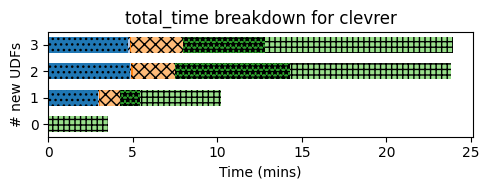

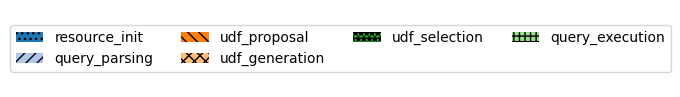

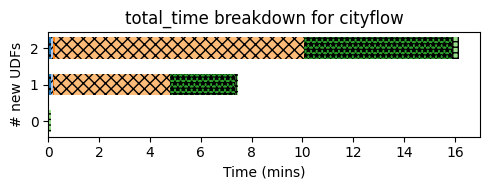

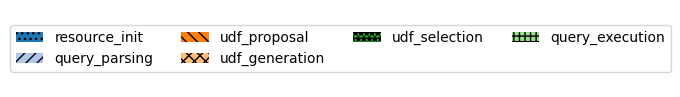

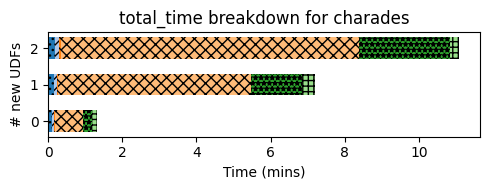

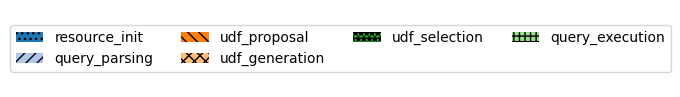

In [105]:
datasets = ["clevrer", "cityflow", "charades"]
for dataset in datasets:
    plot_total_time_breakdown(dataset, total_time_df, "total_time", "time")

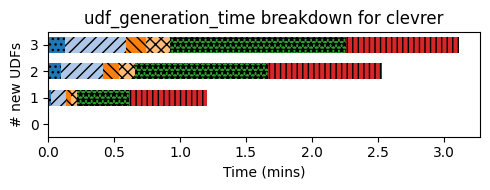

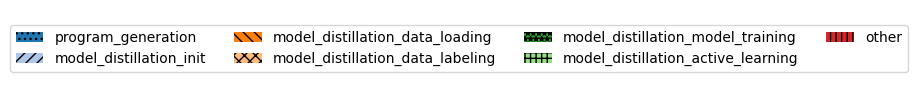

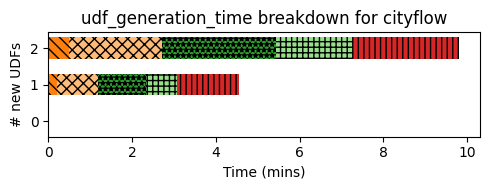

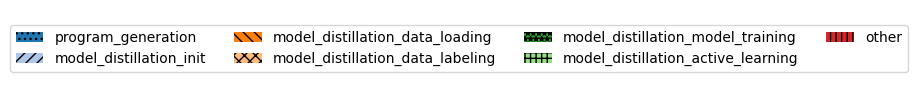

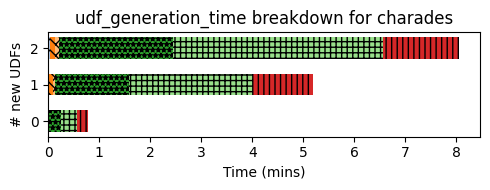

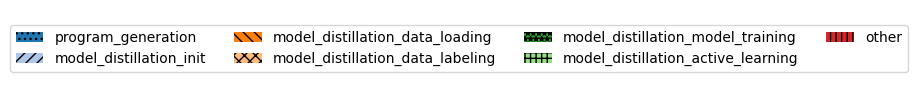

In [106]:
datasets = ["clevrer", "cityflow", "charades"]
for dataset in datasets:
    plot_total_time_breakdown(dataset, udf_generation_time_df, "udf_generation_time", "time")

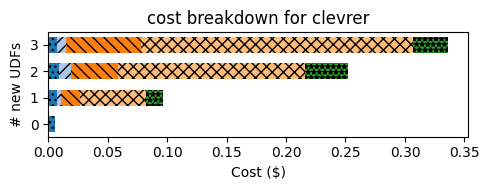

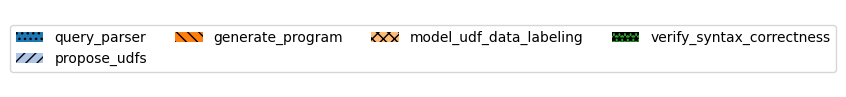

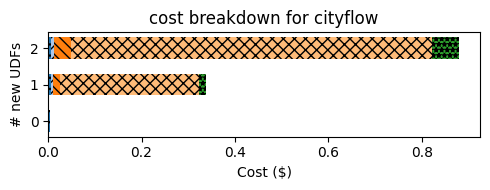

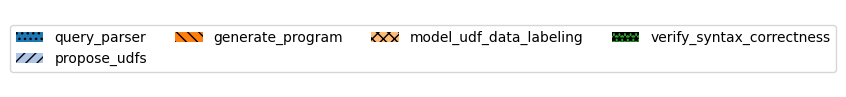

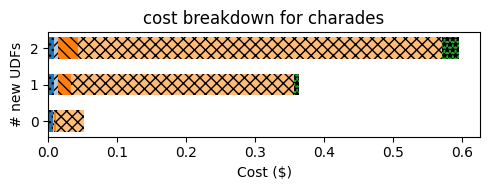

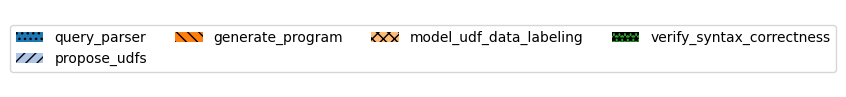

In [107]:
datasets = ["clevrer", "cityflow", "charades"]
for dataset in datasets:
    plot_total_time_breakdown(dataset, cost_df, "cost", "cost")